In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
%matplotlib inline

In [2]:
from zipfile import ZipFile
import geopandas as gpd
from shapely.geometry import Point

In [3]:
import folium
import json

In [4]:
pd.options.display.max_columns = None
display(HTML("<style>.container { width:100% !important; }</style>"))

# Data

In this notebook, I use geospatial data provided by the United States Census Bureau. The US Census Bureau hosts a **massive** amount of data. As a result, they've made a lot of different interfaces to help you find data. I've used the [American Fact Finder interface](https://factfinder.census.gov/faces/nav/jsf/pages/download_center.xhtml) to download the 2011-2015 American Community Survey Estimates. To get this data set, you can get it from the data section of this notebook's [github repository](https://github.com/MattTriano/personal_site_public/tree/master/data/census), or you can go to the **American Fact Finder** site and select:
* **Dataset** $\rightarrow$
    * *Select a Program:* **American Community Survey**
    * *Select a dataset and click Add to Your Selections:* **2015 ACS 5-year estimates**
    * Then click the button below the list of ACS options, then click **NEXT**.
* **Geographies** $\rightarrow$ 
    * *Select a geographic type:*  **Census Tract**
    * *Select a state:* **Illinois**
    * *Select a county:* **Cook**
    * *Select one or more geographic areas and click Add to Your Selections:* **All Census Tracts within Cook County, Illinois**
    * click **ADD TO YOUR SELECTIONS**, then click **NEXT**.
* **Search Results** $\rightarrow$
    * Type **ACS DEMOGRAPHIC AND HOUSING ESTIMATES** or **DP05** in the search field, and press enter.
    * Click the check box to the left of the **ACS DEMOGRAPHIC AND HOUSING ESTIMATES** option, and click **Download**.
    * Click **OK** to prepare the data set for download, then click **DOWNLOAD**.
    
It's kind of a chore to find data sets you found in the past unless you remember the data set ID or table name, but that's the cost of having access to such a massive trove of data.

In [5]:
ZIP_PATH = os.path.join('data', 'census', 'ACS_15_5YR_DP05.zip') 
with ZipFile(ZIP_PATH) as zip_file:
    with zip_file.open('ACS_15_5YR_DP05_with_ann.csv') as my_zipped_csv:
        il_acs_15 = pd.read_csv(my_zipped_csv, header=1)

il_acs_15.head()

Id          Id2  \
0  1400000US17031010100  17031010100   
1  1400000US17031010201  17031010201   
2  1400000US17031010202  17031010202   
3  1400000US17031010300  17031010300   
4  1400000US17031010400  17031010400   

                                    Geography  \
0     Census Tract 101, Cook County, Illinois   
1  Census Tract 102.01, Cook County, Illinois   
2  Census Tract 102.02, Cook County, Illinois   
3     Census Tract 103, Cook County, Illinois   
4     Census Tract 104, Cook County, Illinois   

   Estimate; SEX AND AGE - Total population  \
0                                      4106   
1                                      7229   
2                                      2304   
3                                      6077   
4                                      5011   

   Margin of Error; SEX AND AGE - Total population  \
0                                              468   
1                                              942   
2                                              271   
3                                              694   
4                                              544   

   Percent; SEX AND AGE - Total population  \
0                                     4106   
1                                     7229   
2                                     2304   
3                                     6077   
4                                     5011   

  Percent Margin of Error; SEX AND AGE - Total population  \
0                                                (X)        
1                                                (X)        
2                                                (X)        
3                                                (X)        
4                                                (X)        

   Estimate; SEX AND AGE - Total population - Male  \
0                                             1891   
1                                             3554   
2                                             1215   
3                                             3095   
4                                             2067   

   Margin of Error; SEX AND AGE - Total population - Male  \
0                                                267        
1                                                564        
2                                                199        
3                                                457        
4                                                279        

  Percent; SEX AND AGE - Total population - Male  \
0                                           46.1   
1                                           49.2   
2                                           52.7   
3                                           50.9   
4                                           41.2   

  Percent Margin of Error; SEX AND AGE - Total population - Male  \
0                                                4.7               
1                                                3.6               
2                                                5.2               
3                                                3.9               
4                                                4.7               

   Estimate; SEX AND AGE - Total population - Female  \
0                                               2215   
1                                               3675   
2                                               1089   
3                                               2982   
4                                               2944   

   Margin of Error; SEX AND AGE - Total population - Female  \
0                                                338          
1                                                509          
2                                                163          
3                                                377          
4                                                446          

  Percent; SEX AND AGE - Total population - Female  \
0                                             53.

In [6]:
demographic_df = il_acs_15[['Id2',
                            'Percent; RACE - One race',
                            'Percent; RACE - One race - White', 
                            'Percent; RACE - One race - Black or African American', 
                            'Percent; RACE - One race - Asian', 
                            'Percent; RACE - One race - Some other race',
                            'Percent; SEX AND AGE - Total population - Male',
                            'Percent; SEX AND AGE - Total population - Female',
                            'Percent; SEX AND AGE - Under 5 years',
                            'Percent; SEX AND AGE - 5 to 9 years',
                            'Percent; SEX AND AGE - 10 to 14 years',
                            'Percent; SEX AND AGE - 15 to 19 years',
                            'Percent; SEX AND AGE - 20 to 24 years',
                            'Percent; SEX AND AGE - 25 to 34 years',
                            'Percent; SEX AND AGE - 35 to 44 years',
                            'Percent; SEX AND AGE - 45 to 54 years',
                            'Percent; SEX AND AGE - 55 to 59 years',
                            'Percent; SEX AND AGE - 60 to 64 years',
                            'Percent; SEX AND AGE - 65 to 74 years',
                            'Percent; SEX AND AGE - 75 to 84 years',
                            'Percent; SEX AND AGE - 85 years and over']].copy()
demographic_df['Id2'] = demographic_df['Id2'].astype(str)

## Chicago's Census Tracts

This demographic data is interesting, but if we want to map it out, we need a way to connect these demographic data points to their geographic locations. Fortunately, we can download a **shapefile** describing the geometries and names of all the census tracts in Chicago from [Chicago's Data Portal](https://www.cityofchicago.org/city/en/depts/doit/dataset/boundaries_-_censustracts.html) (click **menu**, then click **Download** as a **Shapefile**).

In [7]:
ZIP_SHP_PATH = os.path.join('zip://', 'data', 'census', 'Boundaries - Census Tracts - 2010.zip')
coord_system = {'init': 'epsg:4326'}
chicago_census_tracts = gpd.read_file(ZIP_SHP_PATH).to_crs(coord_system)

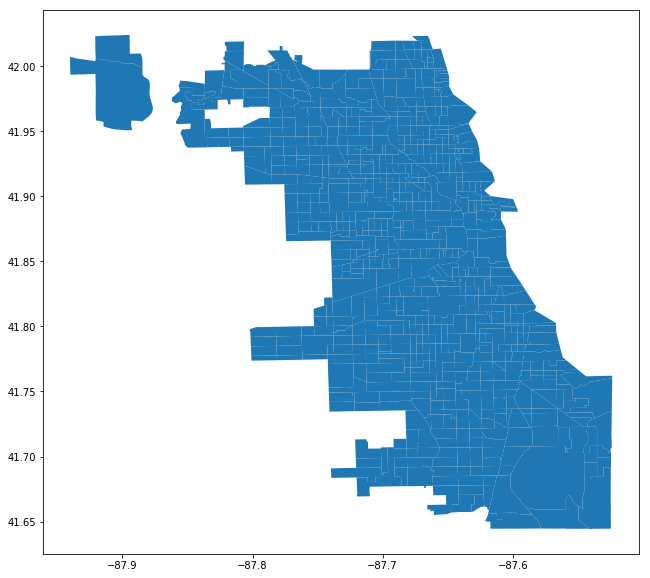

In [8]:
chicago_census_tracts.plot(figsize=(15,10))

In [9]:
chicago_census_tracts.head()

statefp10 countyfp10 tractce10         namelsad10 commarea      geoid10  \
0        17        031    842400  Census Tract 8424       44  17031842400   
1        17        031    840300  Census Tract 8403       59  17031840300   
2        17        031    841100  Census Tract 8411       34  17031841100   
3        17        031    841200  Census Tract 8412       31  17031841200   
4        17        031    838200  Census Tract 8382       28  17031838200   

   commarea_n name10 notes                                           geometry  
0        44.0   8424  None  POLYGON ((-87.62404799998049 41.73021699998396...  
1        59.0   8403  None  POLYGON ((-87.6860799999848 41.82295600001154,...  
2        34.0   8411  None  POLYGON ((-87.62934700001183 41.8527970000265,...  
3        31.0   8412  None  POLYGON ((-87.68813499997718 41.85569099999095...  
4        28.0   8382  None  POLYGON ((-87.66781999997529 41.8741839999791,...

To merge the geographic data to the demographic data, I need to find a column that both sets of data share. The geographic data's **geoid10** column looks a lot like the **Id2** column in the demographic data (and it does have the form of a census tract id). But before I can use this shared feature to merge these data sets, I need to make sure the values have the same type.

We see that in the geospatial data set, the **geoid10** feature is of the 'object' type (which is pandas way of saying it's of the 'string' type), but in the demographic data, **Id2**, is of the 'integer' type. 

In [10]:
chicago_census_tracts.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 801 entries, 0 to 800
Data columns (total 10 columns):
statefp10     801 non-null object
countyfp10    801 non-null object
tractce10     801 non-null object
namelsad10    801 non-null object
commarea      801 non-null object
geoid10       801 non-null object
commarea_n    801 non-null float64
name10        801 non-null object
notes         12 non-null object
geometry      801 non-null object
dtypes: float64(1), object(9)
memory usage: 62.7+ KB


In [11]:
demographic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 21 columns):
Id2                                                     1320 non-null object
Percent; RACE - One race                                1320 non-null object
Percent; RACE - One race - White                        1320 non-null object
Percent; RACE - One race - Black or African American    1320 non-null object
Percent; RACE - One race - Asian                        1320 non-null object
Percent; RACE - One race - Some other race              1320 non-null object
Percent; SEX AND AGE - Total population - Male          1320 non-null object
Percent; SEX AND AGE - Total population - Female        1320 non-null object
Percent; SEX AND AGE - Under 5 years                    1320 non-null object
Percent; SEX AND AGE - 5 to 9 years                     1320 non-null object
Percent; SEX AND AGE - 10 to 14 years                   1320 non-null object
Percent; SEX AND AGE - 15 to 19 years         

So I'll just coerce the **Id2** feature to be strings.

In [12]:
demographic_df['Id2'] = demographic_df['Id2'].astype(str)

In [13]:
demographic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1320 entries, 0 to 1319
Data columns (total 21 columns):
Id2                                                     1320 non-null object
Percent; RACE - One race                                1320 non-null object
Percent; RACE - One race - White                        1320 non-null object
Percent; RACE - One race - Black or African American    1320 non-null object
Percent; RACE - One race - Asian                        1320 non-null object
Percent; RACE - One race - Some other race              1320 non-null object
Percent; SEX AND AGE - Total population - Male          1320 non-null object
Percent; SEX AND AGE - Total population - Female        1320 non-null object
Percent; SEX AND AGE - Under 5 years                    1320 non-null object
Percent; SEX AND AGE - 5 to 9 years                     1320 non-null object
Percent; SEX AND AGE - 10 to 14 years                   1320 non-null object
Percent; SEX AND AGE - 15 to 19 years         

Here's the merge, which does most of the cool work, despite only being one little line.

In [14]:
chicago_demos = pd.merge(left=chicago_census_tracts, right=demographic_df, left_on='geoid10', right_on='Id2')
chicago_demos.head()

statefp10 countyfp10 tractce10         namelsad10 commarea      geoid10  \
0        17        031    842400  Census Tract 8424       44  17031842400   
1        17        031    840300  Census Tract 8403       59  17031840300   
2        17        031    841100  Census Tract 8411       34  17031841100   
3        17        031    841200  Census Tract 8412       31  17031841200   
4        17        031    838200  Census Tract 8382       28  17031838200   

   commarea_n name10 notes                                           geometry  \
0        44.0   8424  None  POLYGON ((-87.62404799998049 41.73021699998396...   
1        59.0   8403  None  POLYGON ((-87.6860799999848 41.82295600001154,...   
2        34.0   8411  None  POLYGON ((-87.62934700001183 41.8527970000265,...   
3        31.0   8412  None  POLYGON ((-87.68813499997718 41.85569099999095...   
4        28.0   8382  None  POLYGON ((-87.66781999997529 41.8741839999791,...   

           Id2 Percent; RACE - One race Percent; RACE - One race - White  \
0  17031842400                    100.0                              0.0   
1  17031840300                     95.4                             49.4   
2  17031841100                     96.3                              3.3   
3  17031841200                     98.2                             51.8   
4  17031838200                     96.6                             53.6   

  Percent; RACE - One race - Black or African American  \
0                                              100.0     
1                                                3.8     
2                                                4.5     
3                                                3.9     
4                                               23.3     

  Percent; RACE - One race - Asian Percent; RACE - One race - Some other race  \
0                              0.0                                        0.0   
1                             20.1                                       18.6   
2                             88.1                                        0.4   
3                              0.4                                       42.0   
4                             15.2                                        4.4   

  Percent; SEX AND AGE - Total population - Male  \
0                                           48.3   
1                                           51.2   
2                                           51.8   
3                                           53.1   
4                                           56.5   

  Percent; SEX AND AGE - Total population - Female  \
0                                             51.7   
1                                             48.8   
2                                             48.2   
3                                             46.9   
4                                             43.5   

  Percent; SEX AND AGE - Under 5 years Percent; SEX AND AGE - 5 to 9 years  \
0                                  4.3                                 3.4   
1                                  9.1                                 6.1   
2                                  4.7                                 4.0   
3                                  8.1                                10.3   
4                                  1.4                                 0.6   

  Percent; SEX AND AGE - 10 to 14 years Percent; SEX AND AGE - 15 to 19 years  \
0                                   6.4                                   3.2   
1                                   6.9                                   6.0   
2                                   6.7                                   7.6   
3                                  12.3                                   7.6   
4                                   4.9                                  22.4   

  Percent; SEX AND AGE - 20 to 24 years Percent; SEX AND AGE - 25 to 34 years  \
0                                   2.7                                   8.6   
1  

From the printout of types that we saw above, all of the demographic data also had the 'object' (string) type. That's no good, as those should be numbers which can be compared. Pandas is smart about automatically choosing the right data type, so when it chooses the a data type we didn't expect, it's because some of the rows contain bad values. Attempting to coerce to a numeric type (like 'float') returned an error message saying '-' couldn't be converted to a numeric type, so I looked for the rows where demographic features contained '-', and found three rows.

In [15]:
chicago_demos[chicago_demos['Percent; SEX AND AGE - Total population - Female'] == '-']

statefp10 countyfp10 tractce10         namelsad10 commarea      geoid10  \
85         17        031    980100  Census Tract 9801       56  17031980100   
414        17        031    381700  Census Tract 3817       38  17031381700   
667        17        031    980000  Census Tract 9800       76  17031980000   

     commarea_n name10                                     notes  \
85         56.0   9801            Half in CA 64 (Midway Airport)   
414        38.0   3817                                      None   
667        76.0   9800  Partially outside City Boundary (O'Hare)   

                                              geometry          Id2  \
85   POLYGON ((-87.73789600001243 41.78578500000872...  17031980100   
414  POLYGON ((-87.62798399996935 41.80191199998851...  17031381700   
667  POLYGON ((-87.92062799997296 42.00453199998842...  17031980000   

    Percent; RACE - One race Percent; RACE - One race - White  \
85                         -                                -   
414                        -                                -   
667                        -                                -   

    Percent; RACE - One race - Black or African American  \
85                                                   -     
414                                                  -     
667                                                  -     

    Percent; RACE - One race - Asian  \
85                                 -   
414                                -   
667                                -   

    Percent; RACE - One race - Some other race  \
85                                           -   
414                                          -   
667                                          -   

    Percent; SEX AND AGE - Total population - Male  \
85                                               -   
414                                              -   
667                                              -   

    Percent; SEX AND AGE - Total population - Female  \
85                                                 -   
414                                                -   
667                                                -   

    Percent; SEX AND AGE - Under 5 years Percent; SEX AND AGE - 5 to 9 years  \
85                                     -                                   -   
414                                    -                                   -   
667                                    -                                   -   

    Percent; SEX AND AGE - 10 to 14 years  \
85                                      -   
414                                     -   
667                                     -   

    Percent; SEX AND AGE - 15 to 19 years  \
85                                      -   
414                                     -   
667                                     -   

    Percent; SEX AND AGE - 20 to 24 years  \
85                                      -   
414                                     -   
667                                     -   

    Percent; SEX AND AGE - 25 to 34 years  \
85                                      -   
414                                     -   
667                                     -   

    Percent; SEX AND AGE - 35 to 44 years  \
85                                      -   
414                                     -   
667                                     -   

    Percent; SEX AND AGE - 45 to 54 years  \
85                                      -   
414                                     -   
667                                     -   

    Percent; SEX AND AGE - 55 to 59 years  \
85                                      -   
414                                     -   
667                                     -   

    Percent; SEX AND AGE - 60 to 64 years  \
85                                      -   
414                                     -   
667                                     -   

    Percent; SEX AND AGE - 65 to 74 years  \
85       

Three census tracts don't have any population data, and that's causing problems. I've plotted these tracts below, and from inspection, I can quickly explain why two of these tracts don't have any population data: they're airports. The upper left tract is O'Hare airport, and the lower left tract is Midway. Per Google, the other tract on the right only includes a strip mall and the Ludwig Van Beethoven Elementary School, so it makes sense that there would be no population. All three of these tracts can be safely zeroed out.

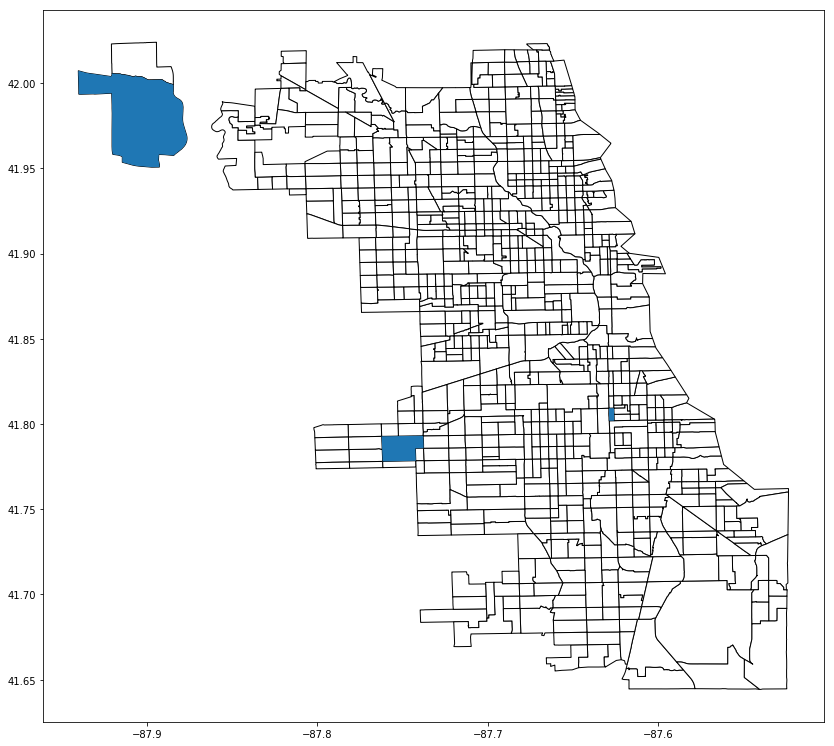

In [16]:
ax = chicago_demos.plot(color='white', edgecolor='black', figsize=(14,14))
chicago_demos[chicago_demos['Id2'].isin(['17031980100', '17031381700', '17031980000'])].plot(ax=ax)

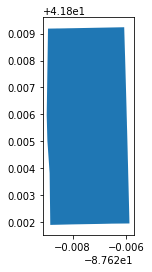

In [17]:
chicago_demos[chicago_demos['Id2'].isin(['17031381700'])].plot()

In [18]:
zero_inds = chicago_demos[chicago_demos['Id2'].isin(['17031980100', '17031381700', '17031980000'])].index.tolist()
for col in chicago_demos.columns:
    if "Percent;" in col:
        chicago_demos.loc[zero_inds, col] = 0

In [19]:
# Coercing these demographic features to the 'float' type
for col in chicago_demos.columns:
    if "Percent;" in col:
        chicago_demos[col] = chicago_demos[col].astype(float)

In [20]:
GeoJSON_PATH = os.path.join('data', 'census', 'Boundaries - Census Tracts - 2010.geojson')
with open(GeoJSON_PATH) as geojson:
    chi_geojson = json.load(geojson)

In [21]:
chi_map = folium.Map(location=[41.85, -87.6], zoom_start=11)

col = 'Percent; RACE - One race - White'

chi_map.choropleth(geo_data=chi_geojson, 
                   data=chicago_demos, 
                   columns=['Id2', col], 
                   key_on='feature.properties.geoid10', 
                   fill_color='YlGn', 
                   legend_name='White Population: Percentage of Census Tract Pop. (Chicago)',
                   fill_opacity=0.6,
                   line_weight=0.3, 
                   highlight=True)

chi_map

# Mapping

Now that we have data in the correct format with the correct type, we can start mapping out some features of interest. You can see all of the base colormaps [here](https://matplotlib.org/tutorials/colors/colormaps.html).

In [22]:
def map_census_data(col, title, gdf, cmap='YlGn', figsize=(14,14), scale=0.65, scale_colors=True):
    if scale_colors:
        vmin = gdf[col].min()
        vmax = gdf[col].max()
    else:
        vmin=0
        vmax=100
    fig, ax = plt.subplots(figsize=figsize)
    base = gdf.plot(color='white', edgecolor='grey', figsize=figsize, ax=ax)
    gdf.plot(column=col, cmap=cmap, ax=base, vmin=vmin, vmax=vmax)
    _ = ax.axis('off')
    _ = ax.set_title('Percentage of Census Tract Pop. (Chicago)\n{}'.format(title), 
                 fontdict={'fontsize': '25', 'fontweight' : '3'})
    _ = ax.annotate('Source: American Community Survey, 2015',
                    xy=(0.1, .1), xycoords='figure fraction',
                    horizontalalignment='left', verticalalignment='top',
                    fontsize=10, color='#555555')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
    sm._A = []
    cbar = fig.colorbar(sm, shrink=scale)
    plt.tight_layout()

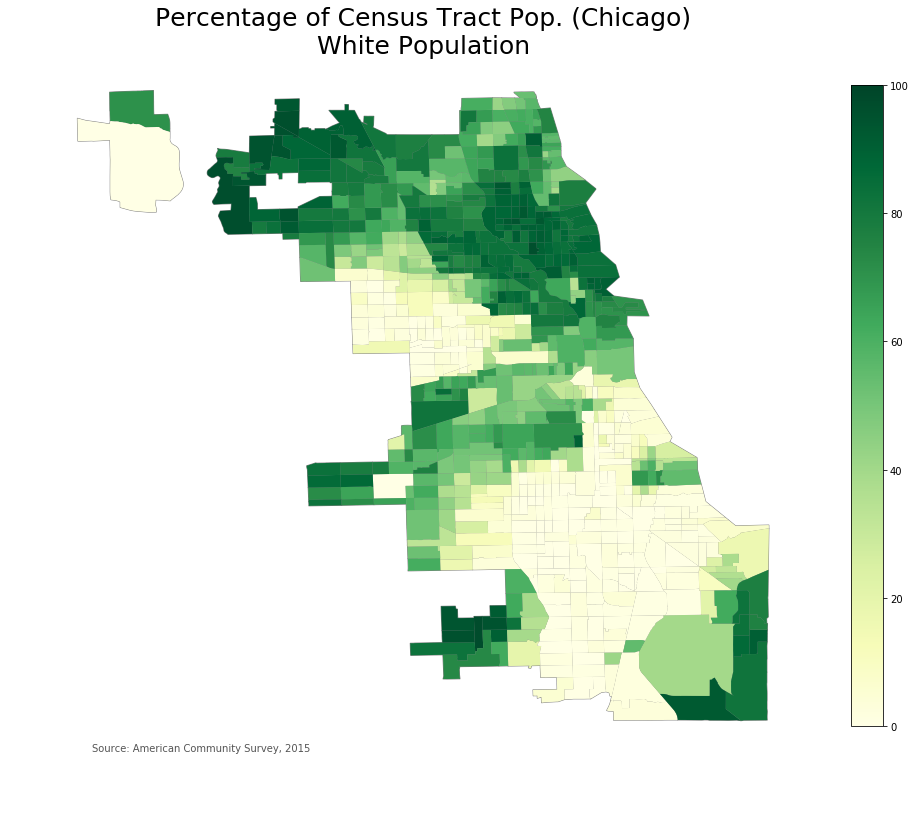

In [23]:
map_census_data(col='Percent; RACE - One race - White', 
                title='White Population',
                cmap='YlGn',
                gdf=chicago_demos, 
                scale_colors=False)

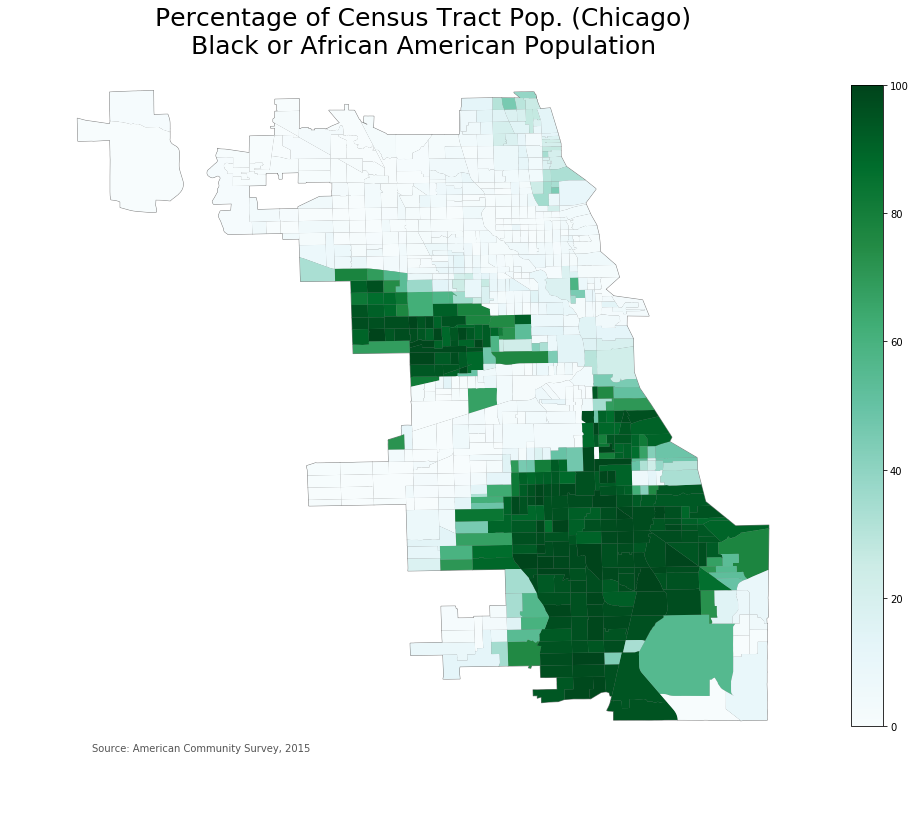

In [24]:
map_census_data(col='Percent; RACE - One race - Black or African American', 
                title='Black or African American Population',
                cmap='BuGn',
                gdf=chicago_demos, 
                scale_colors=False)

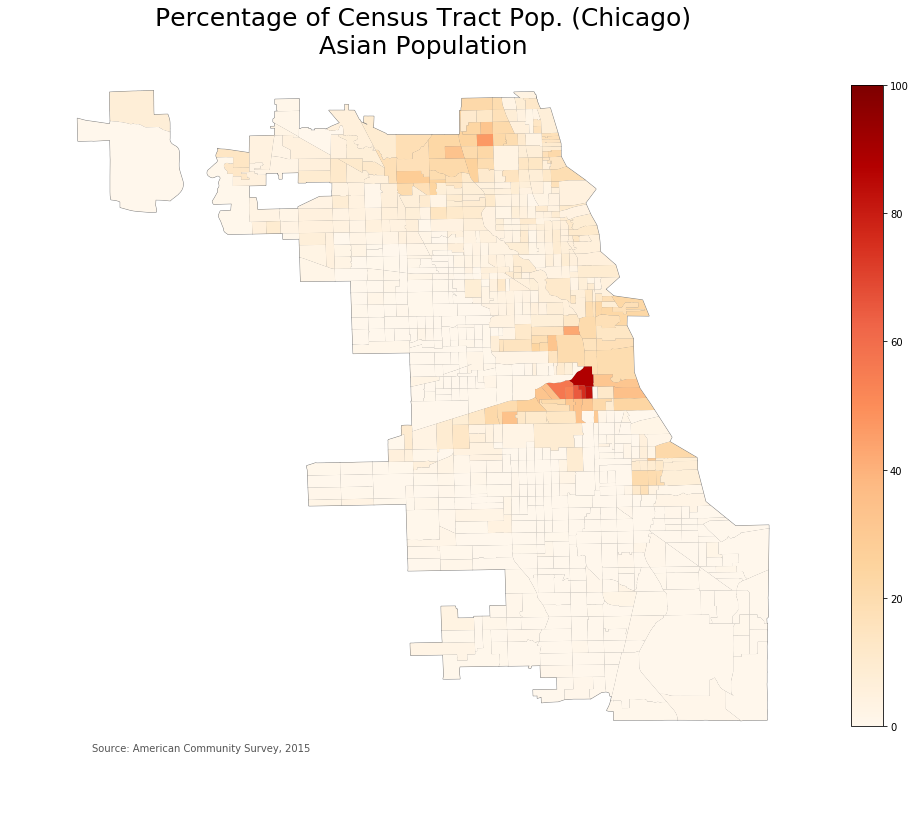

In [25]:
map_census_data(col='Percent; RACE - One race - Asian', 
                title='Asian Population',
                cmap='OrRd',
                gdf=chicago_demos, 
                scale_colors=False)

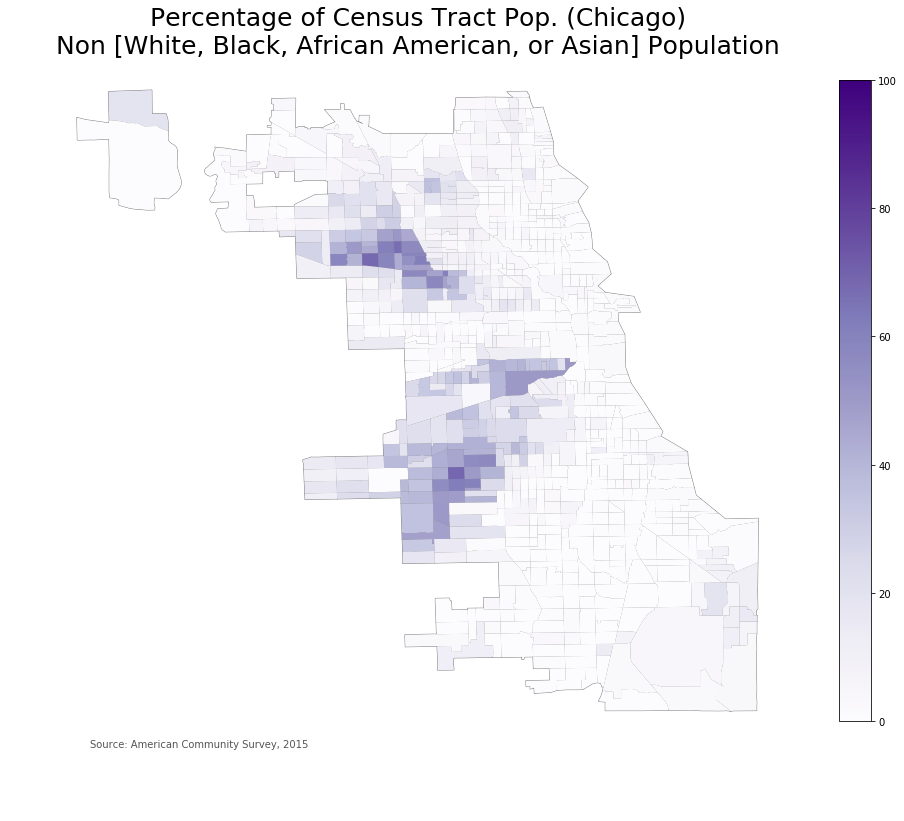

In [26]:
map_census_data(col='Percent; RACE - One race - Some other race', 
                title='Non [White, Black, African American, or Asian] Population',
                cmap='Purples',
                gdf=chicago_demos, 
                scale_colors=False)

That deep green tract in the center? Cook County jail is in that tract.

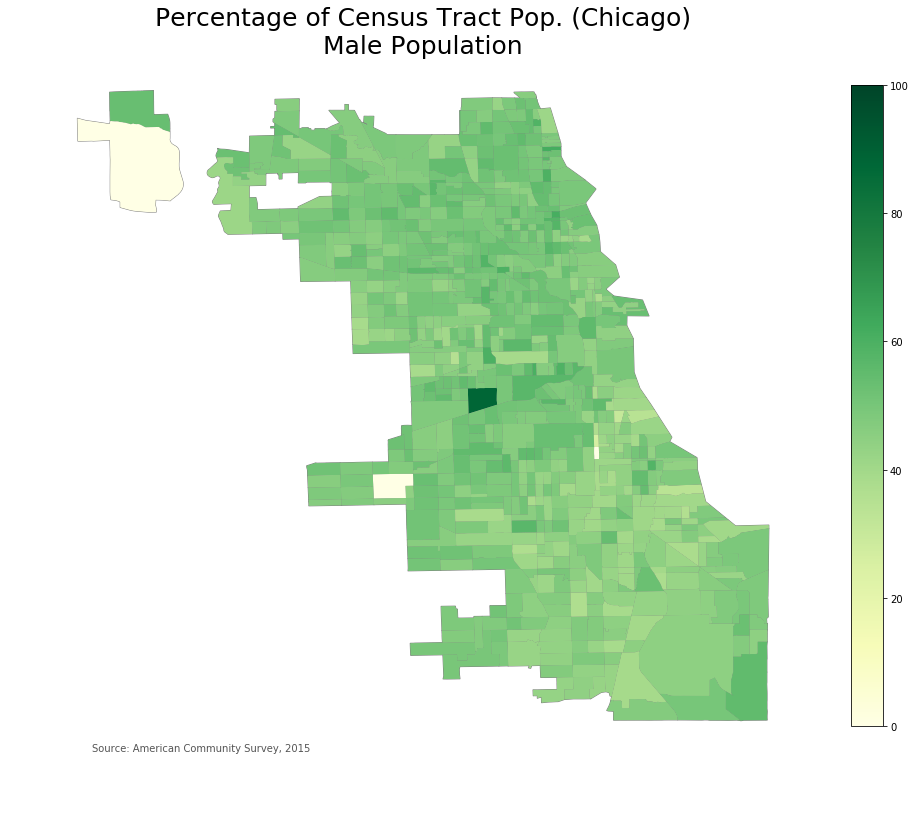

In [27]:
map_census_data(col='Percent; SEX AND AGE - Total population - Male', 
                title='Male Population',
                cmap='YlGn',
                gdf=chicago_demos, 
                scale_colors=False)

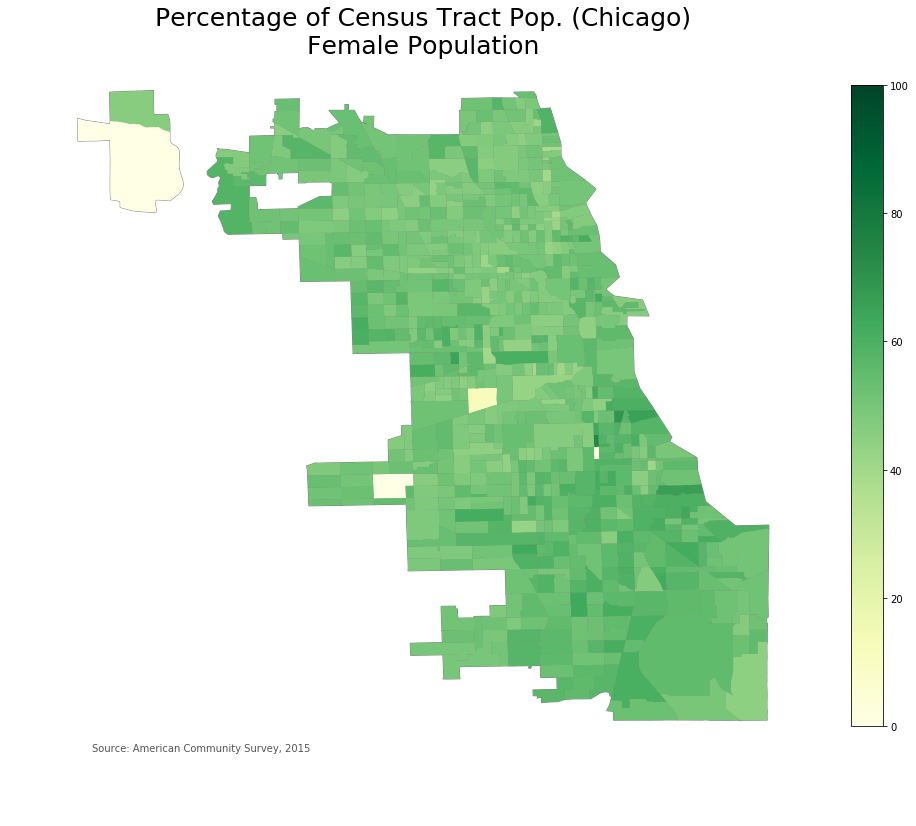

In [28]:
map_census_data(col='Percent; SEX AND AGE - Total population - Female', 
                title='Female Population',
                cmap='YlGn',
                gdf=chicago_demos, 
                scale_colors=False)

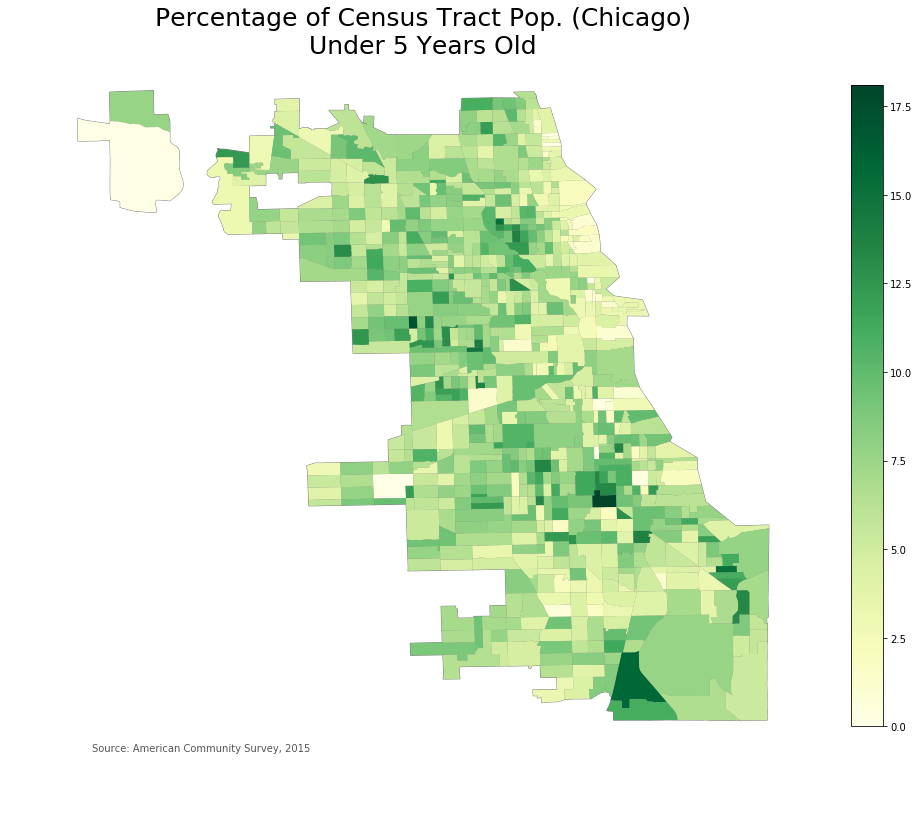

In [29]:
map_census_data(col='Percent; SEX AND AGE - Under 5 years', 
                title='Under 5 Years Old',
                cmap='YlGn',
                gdf=chicago_demos, 
                scale_colors=True)

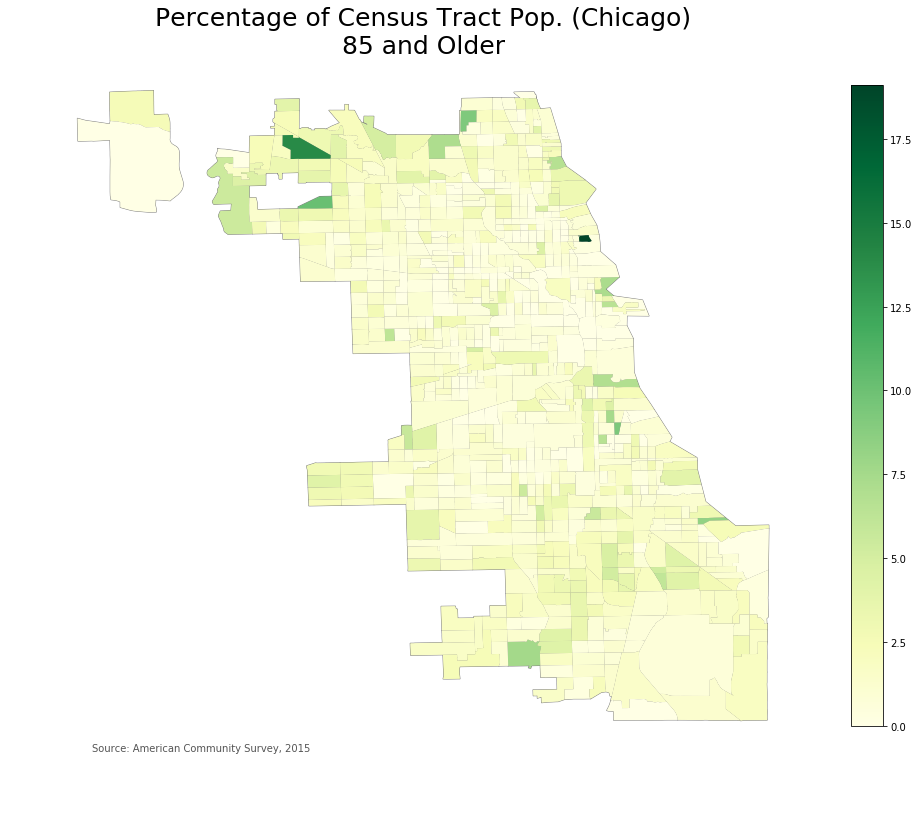

In [30]:
map_census_data(col='Percent; SEX AND AGE - 85 years and over', 
                title='85 and Older',
                cmap='YlGn',
                gdf=chicago_demos, 
                scale_colors=True)

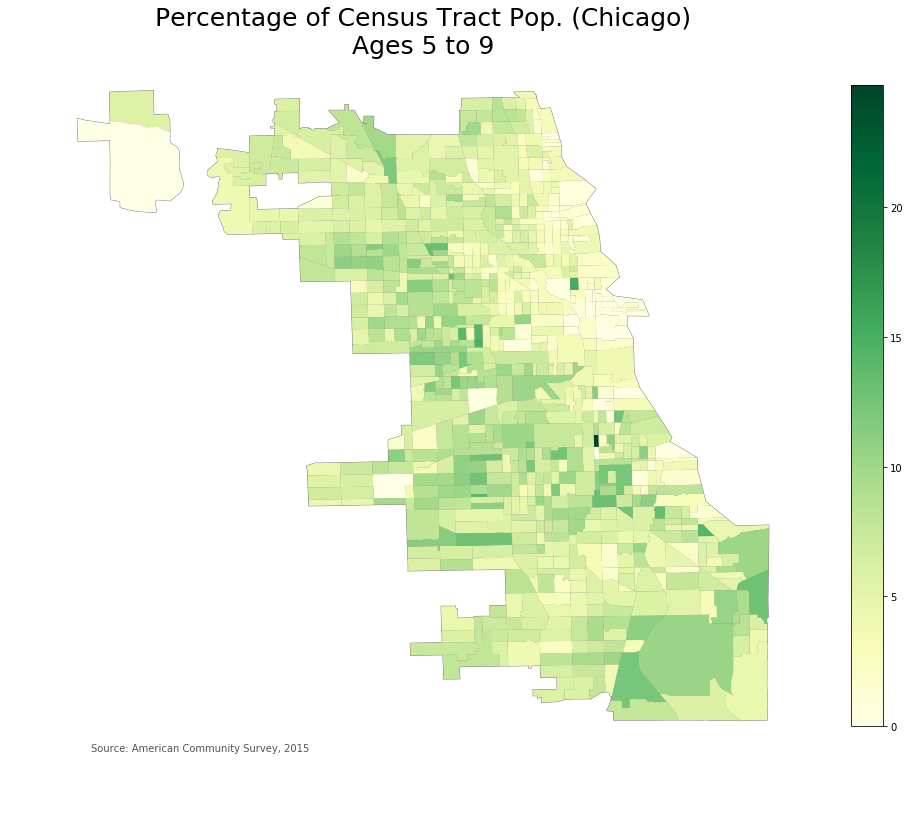

In [31]:
map_census_data(col='Percent; SEX AND AGE - 5 to 9 years', 
                title='Ages 5 to 9',
                cmap='YlGn',
                gdf=chicago_demos, 
                scale_colors=True)

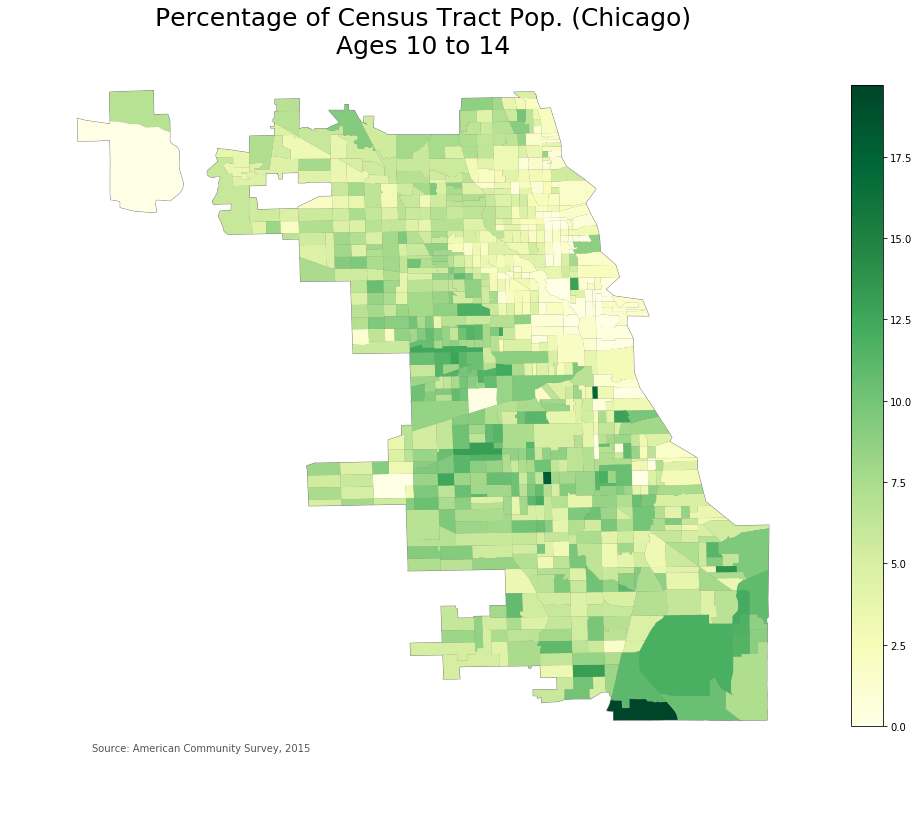

In [32]:
map_census_data(col='Percent; SEX AND AGE - 10 to 14 years', 
                title='Ages 10 to 14',
                cmap='YlGn',
                gdf=chicago_demos,                 
                scale_colors=True)

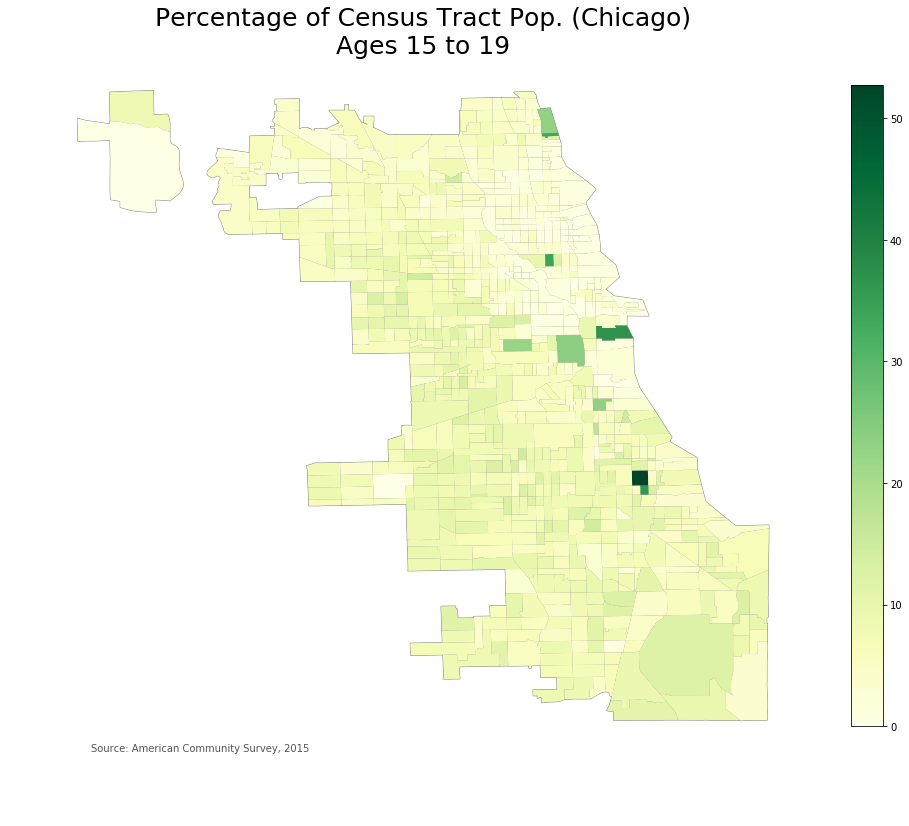

In [33]:
map_census_data(col='Percent; SEX AND AGE - 15 to 19 years', 
                title='Ages 15 to 19',
                cmap='YlGn',
                gdf=chicago_demos,  
                scale_colors=True)

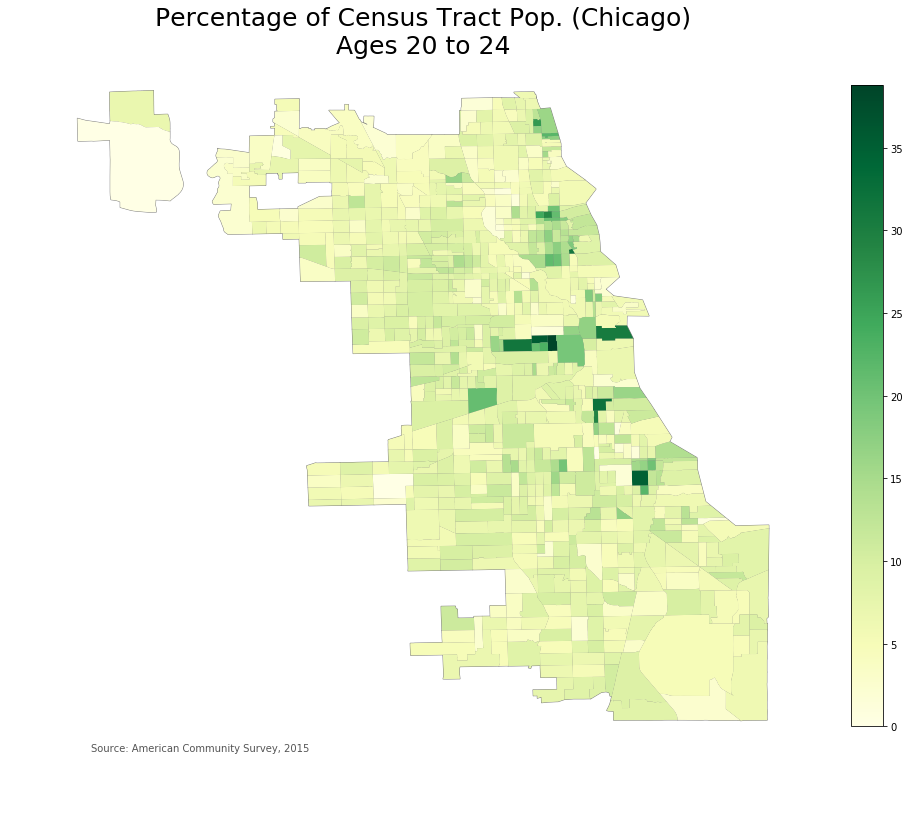

In [34]:
map_census_data(col='Percent; SEX AND AGE - 20 to 24 years', 
                title='Ages 20 to 24',
                cmap='YlGn',
                gdf=chicago_demos,  
                scale_colors=True)

The map below is a perfect match with my intuition.

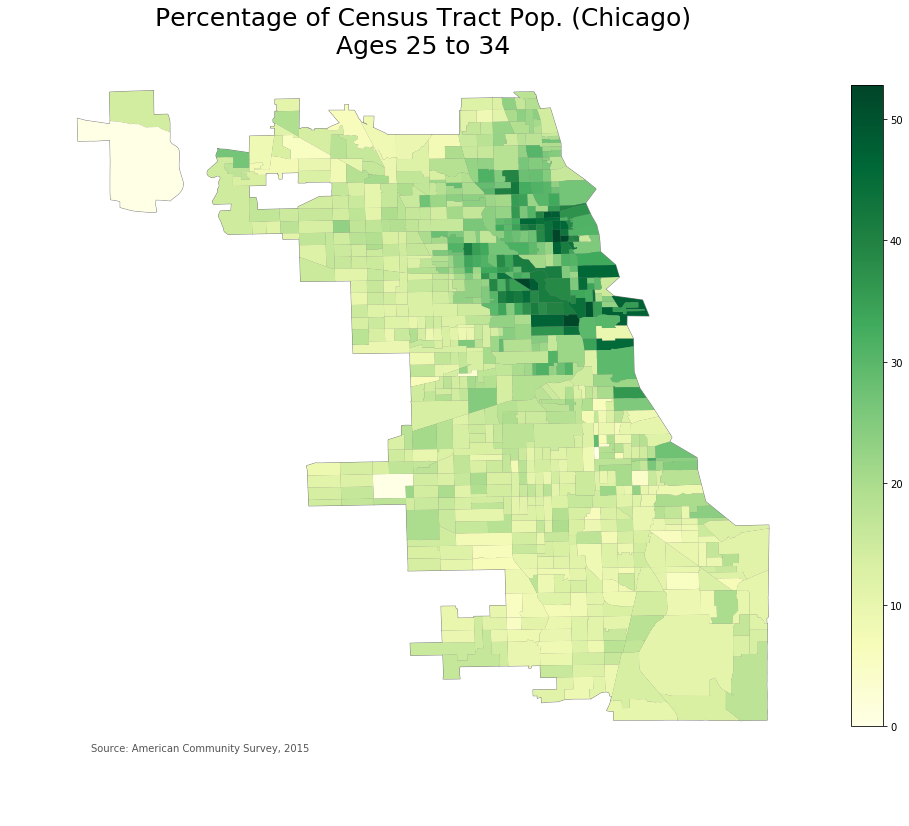

In [35]:
map_census_data(col='Percent; SEX AND AGE - 25 to 34 years', 
                title='Ages 25 to 34',
                cmap='YlGn',
                gdf=chicago_demos,  
                scale_colors=True)

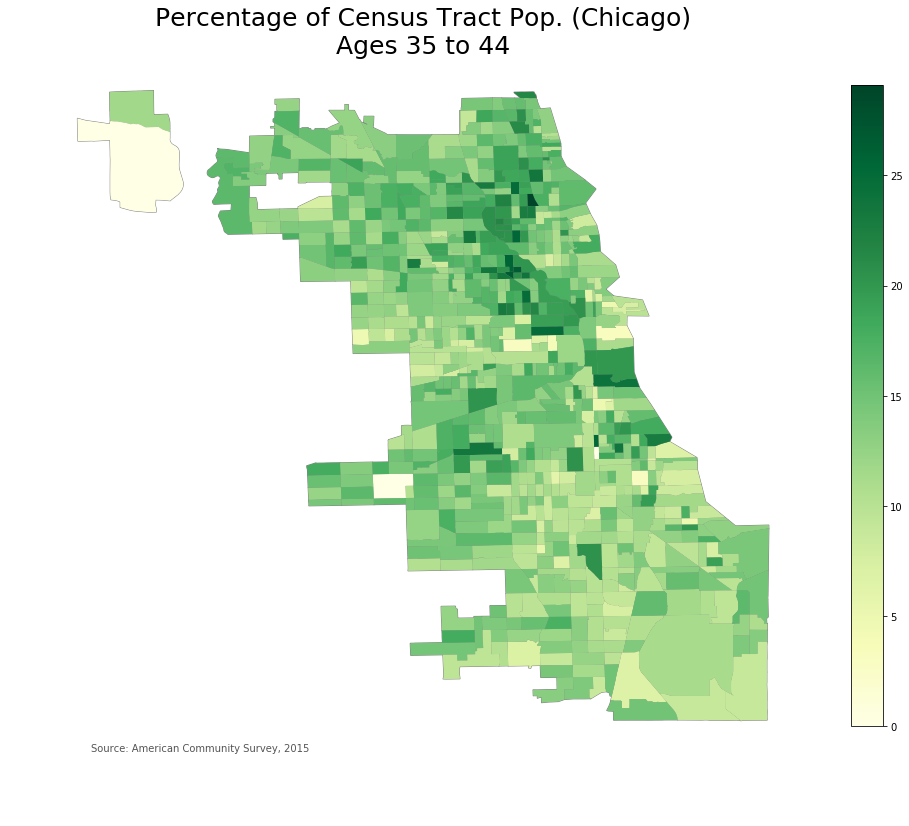

In [36]:
map_census_data(col='Percent; SEX AND AGE - 35 to 44 years', 
                title='Ages 35 to 44',
                cmap='YlGn',
                gdf=chicago_demos, 
                scale_colors=True)

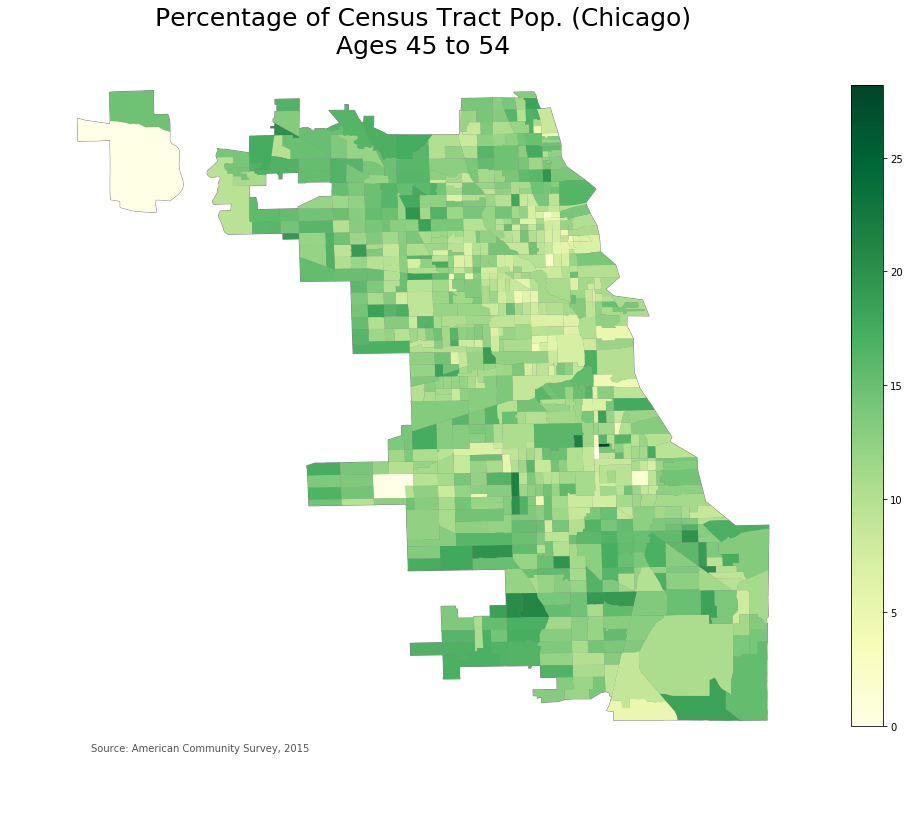

In [37]:
map_census_data(col='Percent; SEX AND AGE - 45 to 54 years', 
                title='Ages 45 to 54',
                cmap='YlGn',
                gdf=chicago_demos, 
                scale_colors=True)

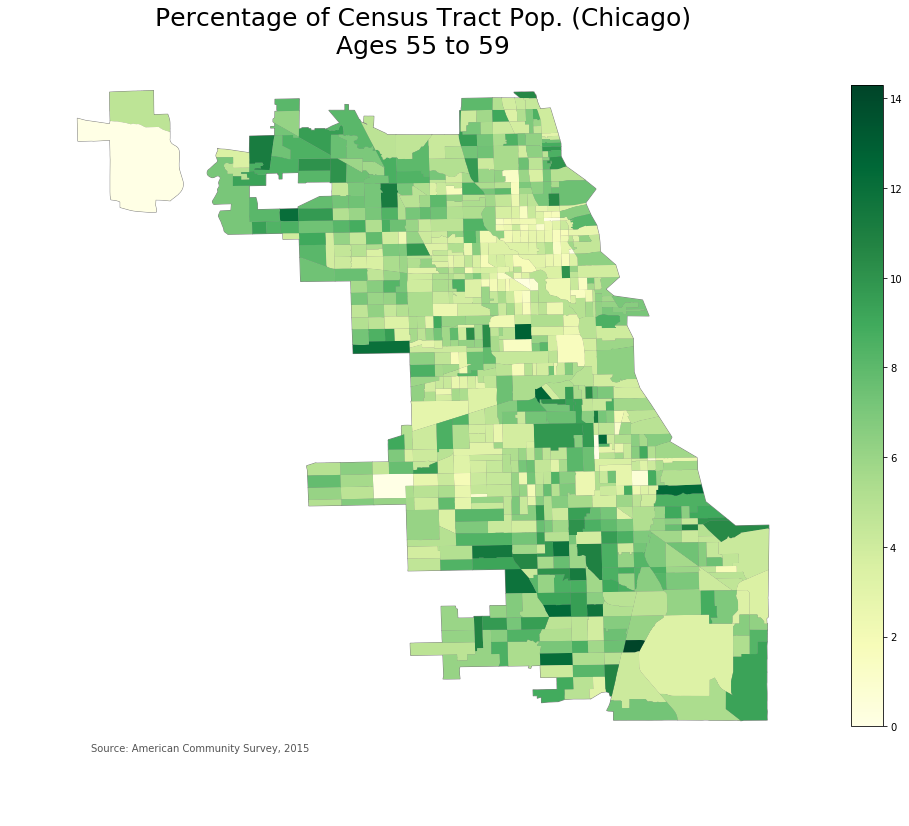

In [38]:
map_census_data(col='Percent; SEX AND AGE - 55 to 59 years', 
                title='Ages 55 to 59',
                cmap='YlGn',
                gdf=chicago_demos,  
                scale_colors=True)

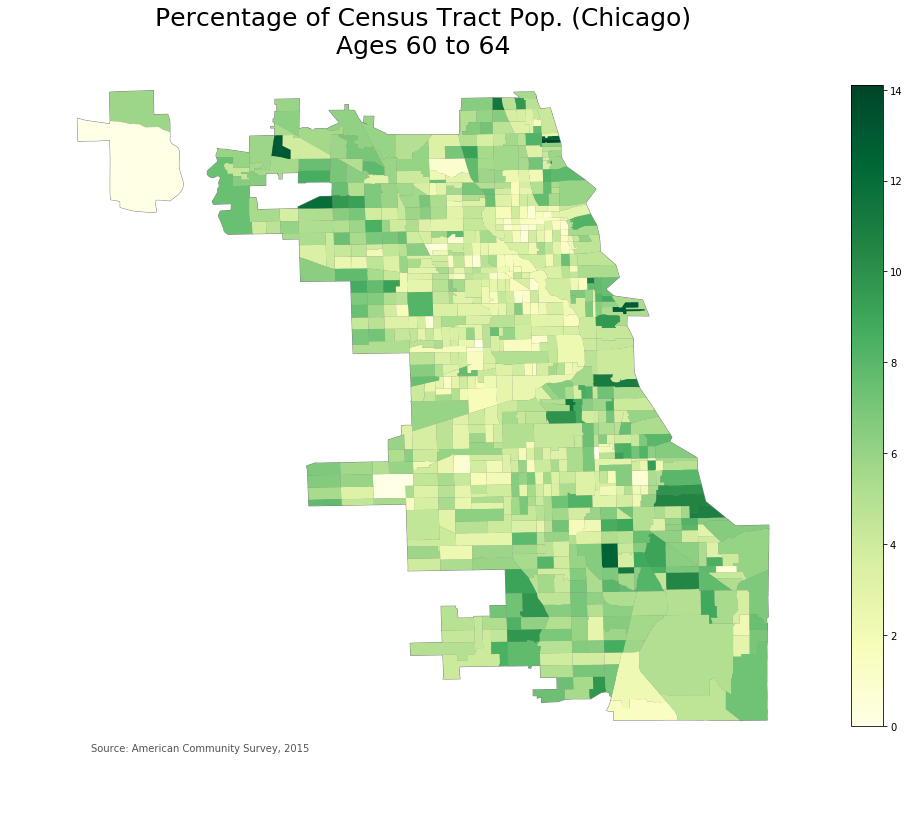

In [39]:
map_census_data(col='Percent; SEX AND AGE - 60 to 64 years' , 
                title='Ages 60 to 64',
                cmap='YlGn',
                gdf=chicago_demos,  
                scale_colors=True)

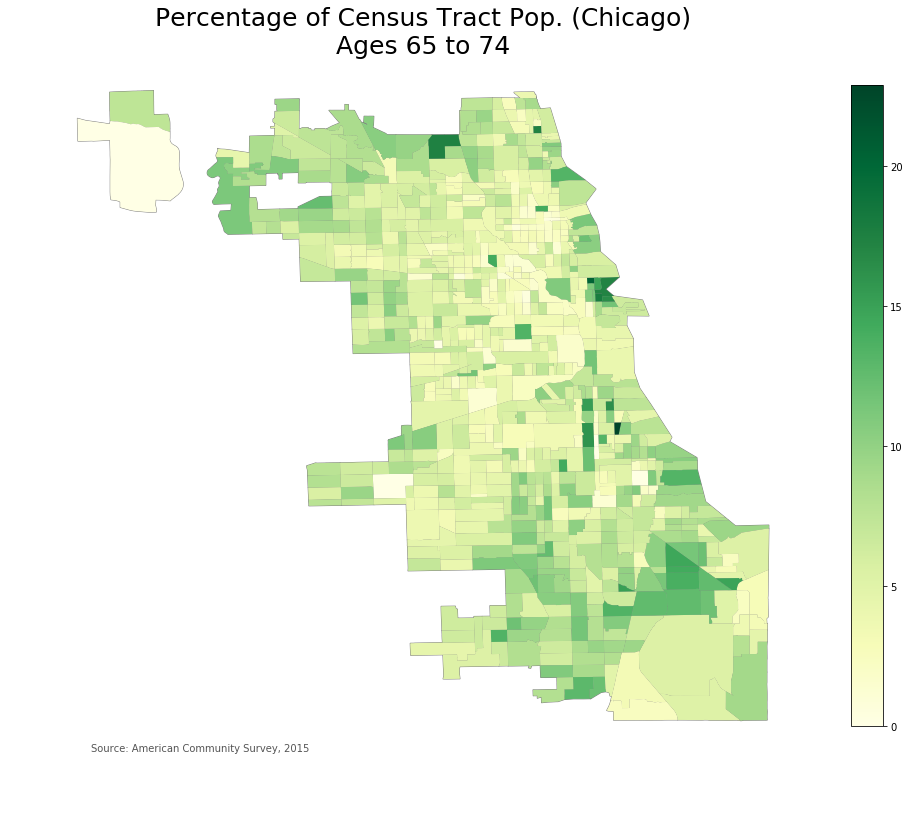

In [40]:
map_census_data(col='Percent; SEX AND AGE - 65 to 74 years', 
                title='Ages 65 to 74',
                cmap='YlGn',
                gdf=chicago_demos,  
                scale_colors=True)

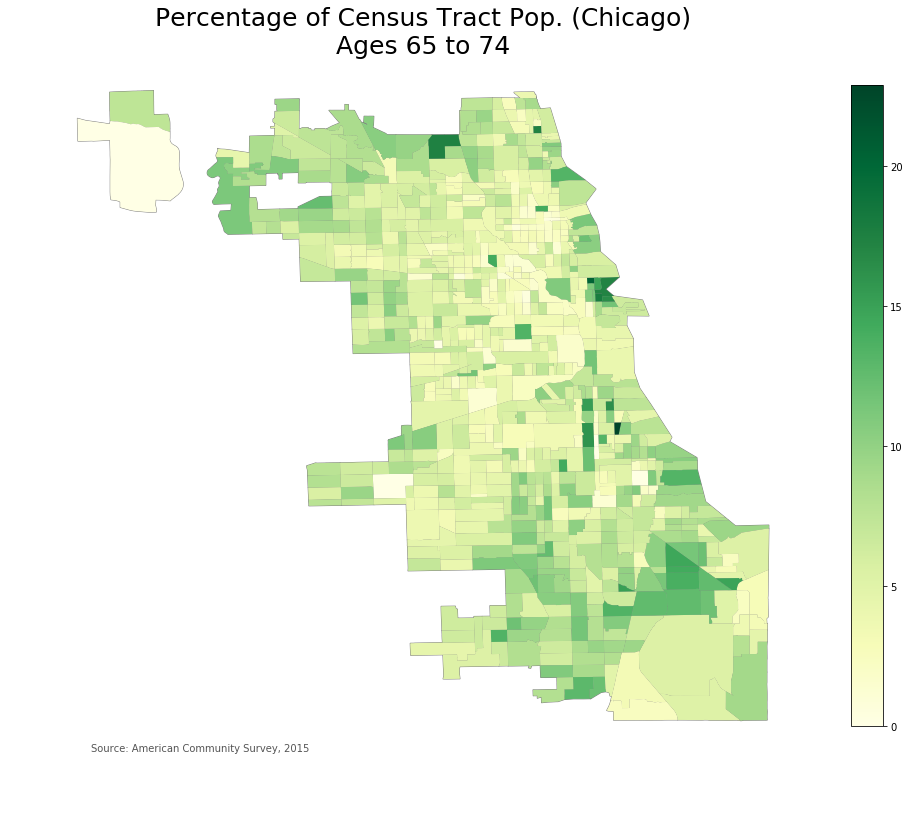

In [41]:
map_census_data(col='Percent; SEX AND AGE - 65 to 74 years', 
                title='Ages 65 to 74',
                cmap='YlGn',
                gdf=chicago_demos,  
                scale_colors=True)